<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/modelingsteps/TrainIllusionModel.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/projects/modelingsteps/TrainIllusionModel.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Example Model Project: the Train Illusion
Marius t'Hart, Megan Peters, Paul Schrater, Gunnar Blohm

**Disclaimer**:  this is a "toy" model used to demonstrate the [10 step procedure of how-to-model](https://doi.org/10.1523/ENEURO.0352-19.2019). It is not meant to be state of the art research.

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/main/sponsors.png?raw=True'/></p>

----
# Phenomenon
*Part of Steps 1-2*

The train illusion occurs when sitting on a train and viewing another train outside the window. Suddenly, the other train *seems* to move, i.e. you experience visual motion of the other train relative to your train. But which train is actually moving?

Often people have the wrong percept. In particular, they think their own train might be moving when it's the other train that moves; or vice versa. The illusion is usually resolved once you gain vision of the surroundings that lets you disambiguate the relative motion; or if you experience strong vibrations indicating that it is indeed your own train that is in motion.

----
# Question

*Part of Step 1*

We asked the following (arbitrary) question for our demo project: "How do noisy vestibular estimates of motion lead to illusory percepts of self motion?"

----
# Background
*Part of Step 2*

You have learned all about the vestibular system in the Intro video. This is also where you would do a literature search to learn more about what's known about self-motion perception and vestibular signals. You would also want to examine any attempts to model self-motion, perceptual decision making and vestibular processing. 

----
# Ingredients

*Part of step 3*

We determined that we probably needed the following ingredients for our model:
* Vestibular input: $v(t)$
* Binary decision output: $d$ - time dependent?
* Decision threshold: $\theta$
* A filter (maybe running average?): $f$
* An integration mechanism to get from vestibular acceleration to sensed velocity: $\int$

----
# Hypotheses

*Part of step 4*

Our main hypothesis is that the strength of the illusion has a linear relationship to the amplitude of vestibular noise. 

Mathematically, this would write as $S = k \cdot N$, where $S$ is the illusion strength and $N$ is the noise level, and $k$ is a free parameter. 
>we could simply use the frequency of occurance across repetitions as the "strength of the illusion"

We would get the noise as the standard deviation of $v(t)$, i.e. $N=\mathbf{E}[v(t)^2]$, where $\mathbf{E}$ stands for the expected value.

Do we need to take the average across time points?
> doesn't really matter because we have the generative process, so we can just use the $\sigma$ that we define

----
# Selected toolkit

*Part of step 5*

We chose to use a [Drift-Diffusion Model (DDM)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) because it is a well-established framework that allows us to model decision making in the case of 2 alternative choices (here: self-motion vs. other train motion).

For our purposes simplest equation looks something like this:  
\begin{align}
\dot e = \frac{de}{dt}= -c \cdot e + v
\end{align},
 where $e$ is the accumulated evidence and $v$ is our vestibular input already containing the noise (so we don't need to add more noise?). $c$ is the leakage constant, i.e. $c=0$ means perfect integration; $c=1$ means no integration (perfect leakage).

----
# Model draft

*Part of step 6*

Brainstorming on the whiteboard, we came up with this...

![picture](https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/modeling_step6.png?raw=1)

----
# Model implementation

*Part of step 7*

We need at least 3 functions:
1. vestibular signal generator
2. integrator (or drift-diffusion mechanism)
3. decision mechanism (threshold comparison)

**Note**: we did not add a filter (yet). We're not sure if we need one...

So let's go step by step... first we need to get set up...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
!pip install pandas --quiet
plt.style.use('dark_background')

### 1. Vestibular signal generator

In [2]:
def vestibular_signal(sig, mov):
  """
  Computes a vestibular signal that corresponds to the acceleration of the
  train with different amplitudes of noise
  Args:
    sig: scalar SD of noise
    mov: 0 means no self-motion; 1 means self-motion (or scaling or motion signal)
  Returns: vector array of vestibular signal v
  """
  # create white noise series for 10s with 1ms resolution
  x = np.linspace(-7, 14, 1001)
  z = 1/(1 + np.exp(-x))
  noise = norm.rvs(size=1000)
  v = sig*noise + mov*np.diff(z)/0.001

  return v

Let's see if that works... (*unit test*)

Text(0, 0.5, 'vestibular signal (a.u.)')

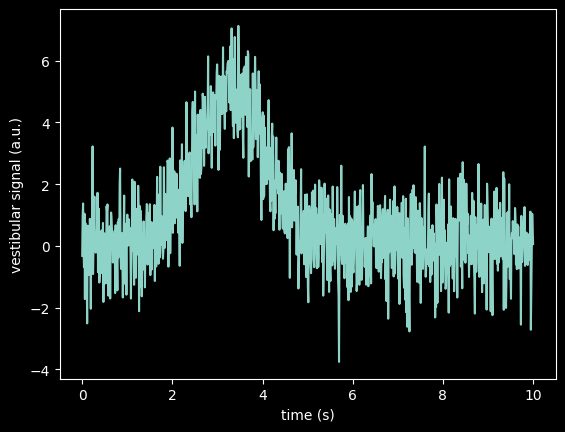

In [3]:
v = vestibular_signal(1,1)

# plot signal
t = np.linspace(0, 10, 1000)
plt.plot(t,v)
plt.xlabel("time (s)")
plt.ylabel("vestibular signal (a.u.)")

### 2. integrator (DDM mechanism)

In [4]:
def ddm(v, c):
  """
  Leaky integration of vestibular signal
  Args:
    v: array of vestibular signal
    c: leakage constant
  Outputs: time series of integrated vestibular signal (with leakage)
    = evidence e
  """
  e = np.random.normal(0, 0.1)
  E = []
  for i in range(len(v)):
    e += -c*e + v[i]*0.001
    E.append(e)
  return E

Let's test the DDM function... (*unit test*)

Text(0, 0.5, 'integrated evidence')

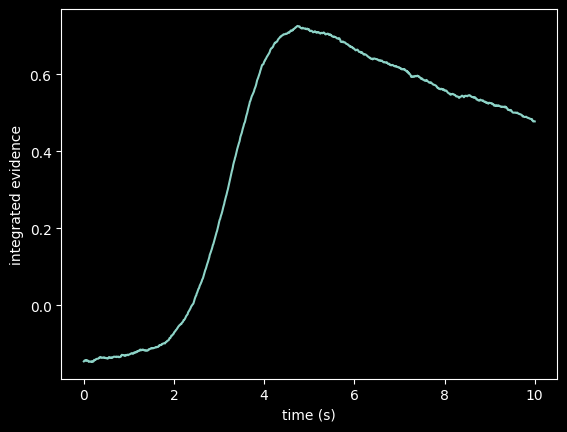

In [5]:
e = ddm(v,c=0.001)

# plot result
plt.plot(t,e)
plt.xlabel("time (s)")
plt.ylabel("integrated evidence")

### 3. thresholding (decision mechanism)

In [6]:
def threshold(e, thr):
  """
  Thresholding of motion evidence
  Args:
    motion evidence: e (array)
    threshold: thr
  Output: decision d if threshold was reached
  """
  d = any(np.array(e) > thr)*1
  return d

Now let's test this function... (*unit test*)

In [7]:
d = threshold(e, .6)
d

1

## Assembling the model

In [8]:
def run_model(sig,c,thr,mov):
  """
  runs the full model to simulate self-motion decision, e.g. for train illusion
  Args:
    sig: SD of vestibular noise
    c: leakage constant
    thr: decision threshold
    mov: self-motion? ) no selfmotion; 1 self-motion
  Output: decision d (0: no self-motion; 1: self-motion)
  """
  v = vestibular_signal(sig, mov)
  e = ddm(v,c)
  d = threshold(e, thr)
  return d

Let's run the model and see if it works...

In [9]:
d = run_model(200,0.001,0.8,1)
d

1

----
# Model completion

*Part of step 8*

So the model seems to work. Running different parameters gives us different results. Are we done?
* **can we answer our question**: yes, in our model the illusion arises because integrating very noisy vestibular signals representing motion evidence sometimes accumulate to a decision threshold and sometimes do not reach that threshold.
* **can we speak to our hypothesis**: yes, we can now simulate different trials with different noise levels (and leakage and thrshold parameters) and evaluate the hypothesized linear relationship between  vestibular noise and how often our perceptual system is fooled...
* **does the model reach our goals**: yes, we wanted to generate a mechanistic model to be able to make some specific predictions that can then be tested experimentally later...



----
# Model evaluation & testing

*Part of step 9*

Ok, so we still need to actually evaluate and test our model performance. Since this is a conceptual model and we don't have actual data (yet), we will evaluate how our model behaves as a function of the 3 parameters. If we had data with different conditions, we could try to fit the model to the data and evaluate the goodness of fit, etc... If other alterative models existed, we could evaluate our model against those alternatives too. 

So let's run out model in different parameter regimes and analyze the result to get some insight into the model performance

In [10]:
import itertools # to automatically generat possible combinations of parameters

# define parameter list
params = {
    'sig': np.linspace(1,21,5)**2,
    'c': np.exp(np.linspace(-10,-1,5)),
    'thr': np.linspace(0,2,5),
    'mov': np.linspace(0,1,2),
}

# run combination of parameters
keys = list(params)
D = []
for i in range(0,100):
  for values in itertools.product(*map(params.get, keys)):
      d = run_model(**dict(zip(keys, values)))
      temp = list(values)
      temp.append(d)
      D.append(temp)

Now let's explicitly test our hypothsis for different parameter combinations...

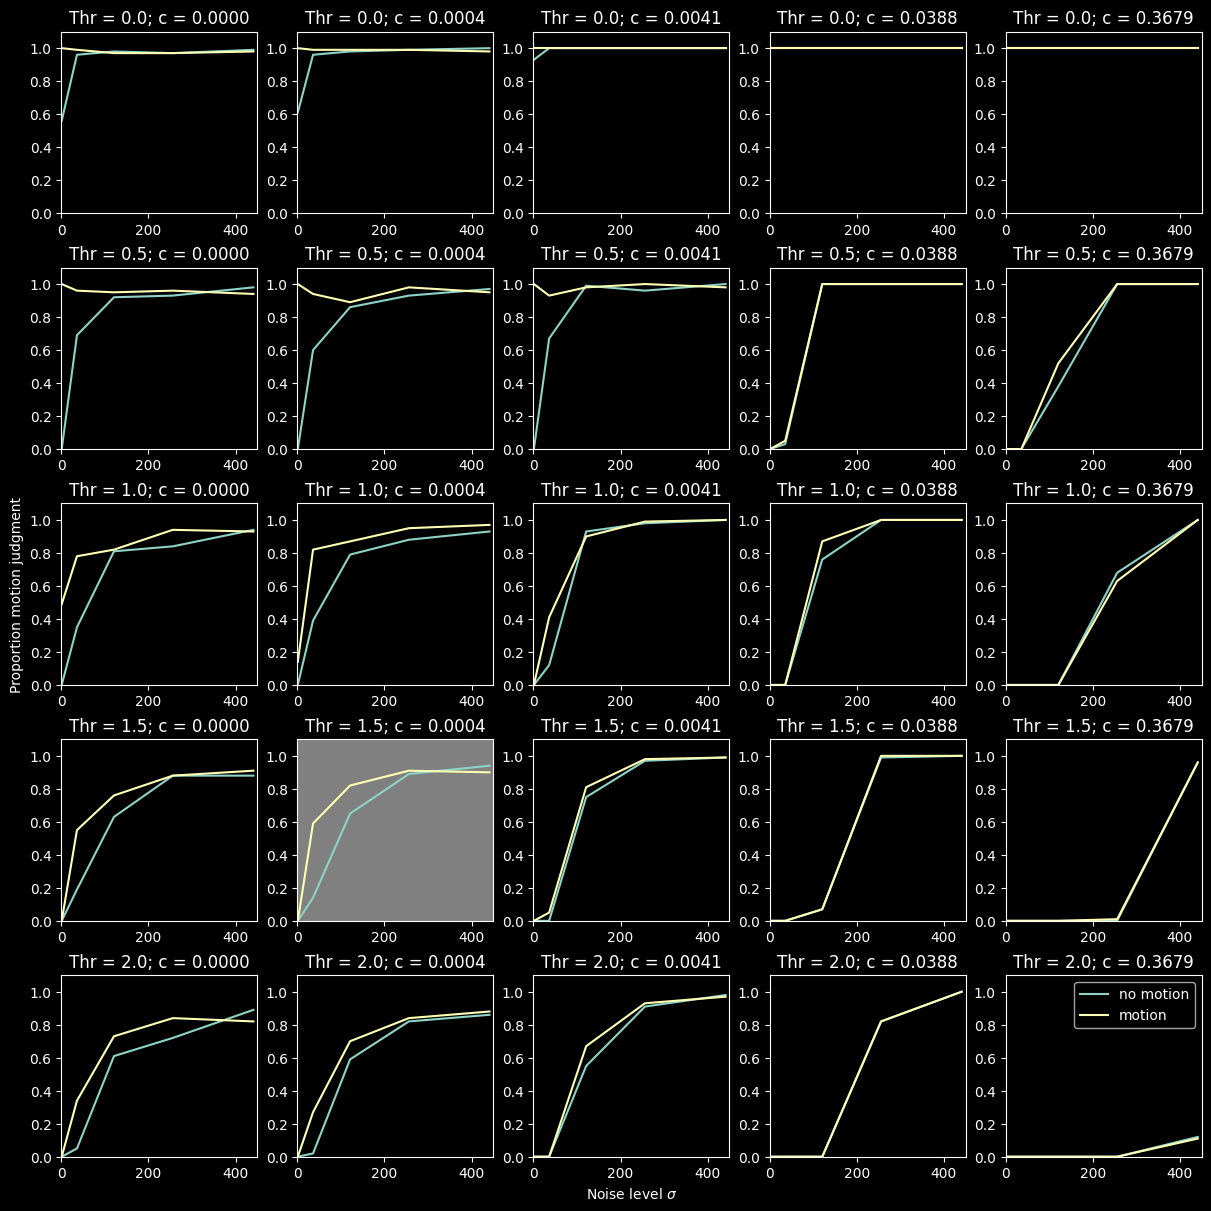

In [11]:
# want data frames:
import pandas as pd
df = pd.DataFrame(D, columns = ['Sig','c','Thr','Mov','Decisions'])
# multi panel layout:
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(5, 5)
# plot for movement absent/present
Mov_s = np.unique(df['Mov'])
# plot for leakage parameter & threshold values:
c_s   = np.unique(df['c'])
Thr_s   = np.unique(df['Thr'])
# plot for data for both movement condition for each leakage/threshold combination
Sig_s   = np.unique(df['Sig'])
for Thr_n in range(len(Thr_s)):
  for c_n in range(len(c_s)):
    subdf0 = df[(df.Mov == 0) & (df.c == c_s[c_n]) & (df.Thr == Thr_s[Thr_n])].groupby(['Sig'])['Decisions'].mean()
    subdf1 = df[(df.Mov == 1) & (df.c == c_s[c_n]) & (df.Thr == Thr_s[Thr_n])].groupby(['Sig'])['Decisions'].mean()
    im0 = axs[Thr_n, c_n].plot(Sig_s, subdf0, label="no motion")
    im1 = axs[Thr_n, c_n].plot(Sig_s, subdf1, label="motion")
    axs[Thr_n, c_n].set_title("Thr = {}; c = {:.4f}".format(Thr_s[Thr_n], c_s[c_n]))
    axs[Thr_n, c_n].set_ylim(0, 1.1)
    axs[Thr_n, c_n].set_xlim(0, 450)
axs[4,2].set_xlabel("Noise level $\sigma$")
axs[2,0].set_ylabel("Proportion motion judgment")
axs[3,1].set_facecolor('grey')
axs[4,4].legend();

There seems to be some parameter redundancy. I.e. we could chose different parameter combinations to make the model do something sensible...

But it looks like $c=0.0004$ works well for $\theta = 1.5$ and $\sigma=50$ (highlighted plot). Lets run a few trials on that to analyze those results more specifically...

In [12]:
# run "best" parameter combination
sig = 50
c = 0.0004
thr = 1.5
d0 = []
d1 = []
for i in range(0,1000):
    d0.append(run_model(sig,c,thr,0))
    d1.append(run_model(sig,c,thr,1))
print('\n Motion detected for no-motion =', sum(d0)/10, '%; and motion =', sum(d1)/10, '%')


 Motion detected for no-motion = 31.3 %; and motion = 61.7 %


This does indeed result in roughly 50% likelihood of experiencing the illusion both ways.

Finally, let's explicitly evaluate our hypothesis...

In [13]:
sig = np.linspace(1,201,20)
c = 0.0004
thr = 1.5
D0 = []
D1 = []
for s in range(len(sig)):
  d0 = []
  d1 = []
  for i in range(0,100):
    d0.append(run_model(sig[s],c,thr,0))
    d1.append(run_model(sig[s],c,thr,1))
  D0.append(sum(d0)/100)
  D1.append(sum(d1)/100)

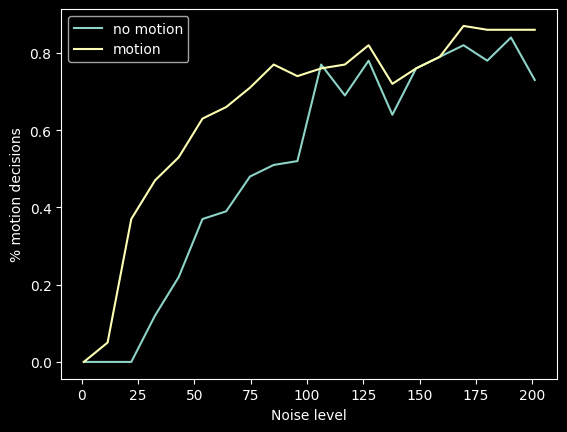

In [14]:
plt.plot(sig,D0, label="no motion")
plt.plot(sig,D1, label ="motion")
plt.xlabel("Noise level")
plt.ylabel("% motion decisions")
plt.legend();

Our **hypothesis** of linear increase of illusion strength with noise only holds true in a limited range of noise... It's monotonic but saturating of course...

**And regarding our original question**: it is really the noise that pushes the integrated signal over the threshold. The less leaky the integration and the lower the threshold, the more motion decisions we get...

----
# Summary
*Part of Step 10*

Let's write a simple abstract following the guidelines...

**A. What is the phenomena**?  Here summarize the part of the phenomena which your modeling addresses.

_The "train illusion" occurs when sitting in a stationary train and experiencing relative visual motion of an adjacent train outside the window; sometimes we feel like we're moving even if we're not (and vice versa). Previous literature has suggested that vestibular signals are used to disambiguate self-motion from motion of an adjacent object._

**B. What is the key scientific question?**:  Clearly articulate the question which your modeling tries to answer.

_How noisy vestibular estimates of motion lead to illusory percepts of self motion is currently unknown._

**C. What was our hypothesis?**:  Explain the key relationships which we relied on to simulate the phenomena.

_We hypothesized that noisy vestibular signals are integrated leading the brain to decide whether self-motion is occurring or not, and that larger noise is linearly associated with more frequent errors in self-motion judgment._

**D. How did your modeling work?** Give an overview of the model, it's main components, and how the modeling works.  ''Here we ... ''

_To investigate this hypothesis, we constructed a drift diffusion model and simulated self-motion decisions under varying noise conditions, when true self motion was occurring or not._

**E. What did you find? Did the modeling work?** Explain the key outcomes of your modeling evaluation. 

_We observed that higher noise did indeed lead to more frequent errors in self-motion perception but this relationship was not linear._

**F. What can you conclude?** Conclude as much as you can _with reference to the hypothesis_, within the limits of the modeling. 

_We conclude that accumulated noisy vestibular information can explain the occurrence of the train illusion, and the higher the noise (or the lower the signal-to-noise ratio), the more frequently such illusions will occur._

**G. What are the limitations and future directions?** What is left to be learned? Briefly argue the plausibility of the approach and/or what you think is essential that may have been left out.

_Future research should investigate whether trial-by-trial variations of noisy vestibular signals actually correlate with self-motion judgments._

>If we put this all in one paragraph, we have our final complete abstract. But, first, do not include the letters in _your_ abstract, and second, we did paraphrase the answers a little so they fit together.

## Abstract
(A) The "train illusion" occurs when sitting in a stationary train and experiencing relative visual motion of an adjacent train outside the window; sometimes we feel like we're moving even if we're not (and vice versa). Previous literature has suggested that vestibular signals are used to disambiguate self-motion from motion of an adjacent object. (B) How noisy vestibular estimates of motion lead to illusory percepts of self motion is currently unknown. (C) We hypothesized that noisy vestibular signals are integrated leading the brain to decide whether self-motion is occurring or not, and that larger noise is linearly associated with more frequent errors in self-motion judgment. (D) To investigate this hypothesis, we constructed a drift diffusion model and simulated self-motion decisions under varying noise conditions, when true self motion was occurring or not. (E) We observed that higher noise did indeed lead to more frequent errors in self-motion perception but this relationship was not linear. (F) We conclude that accumulated noisy vestibular information can explain the occurrence of the train illusion, and the higher the noise (or the lower the signal-to-noise ratio), the more frequently such illusions will occur. (G) Future research should investigate whether trial-by-trial variations of noisy vestibular signals actually correlate with self-motion judgments.

----
# Final thoughts

Note that the model we built here was extremely simple and used artificial data on purpose. It allowed us to go through all the steps of building a model, and hopefully you noticed that it is not always a linear process, you will go back to different steps if you hit a roadblock somewhere.

There are many issues that we did not address in this model. However, if you're interested in how to actually approach modeling a similar phenomenon in a probabilistic way, we encourage you to read the paper by [Dokka et. al., 2019](https://doi.org/10.1073/pnas.1820373116), where the authors model how judgments of heading direction are influenced by objects that are also moving.